INFO:root:Dataset shape: (2392, 15)
INFO:root:Descriptive statistics:
INFO:root:         StudentID          Age       Gender    Ethnicity  ParentalEducation  \
count  2392.000000  2392.000000  2392.000000  2392.000000        2392.000000   
mean   2196.500000    16.468645     0.510870     0.877508           1.746237   
std     690.655244     1.123798     0.499986     1.028476           1.000411   
min    1001.000000    15.000000     0.000000     0.000000           0.000000   
25%    1598.750000    15.000000     0.000000     0.000000           1.000000   
50%    2196.500000    16.000000     1.000000     0.000000           2.000000   
75%    2794.250000    17.000000     1.000000     2.000000           2.000000   
max    3392.000000    18.000000     1.000000     3.000000           4.000000   

       StudyTimeWeekly     Absences     Tutoring  ParentalSupport  \
count      2392.000000  2392.000000  2392.000000      2392.000000   
mean          9.772199    14.541388     0.301421         2.12

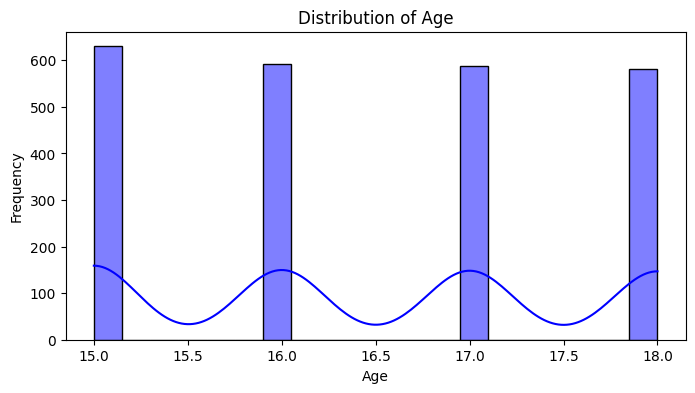

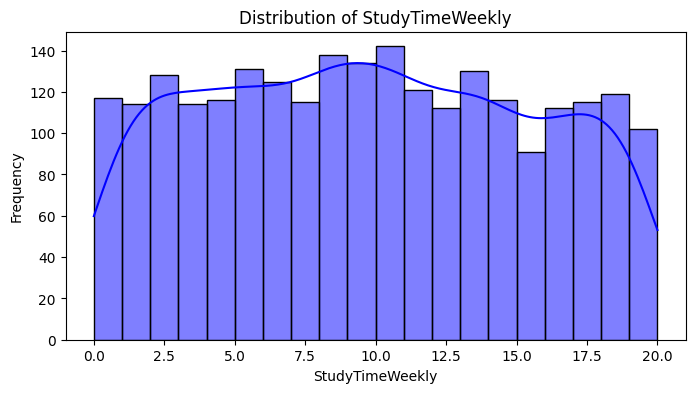

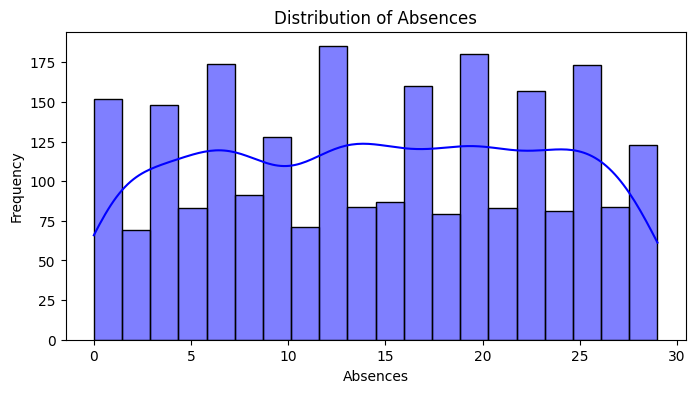

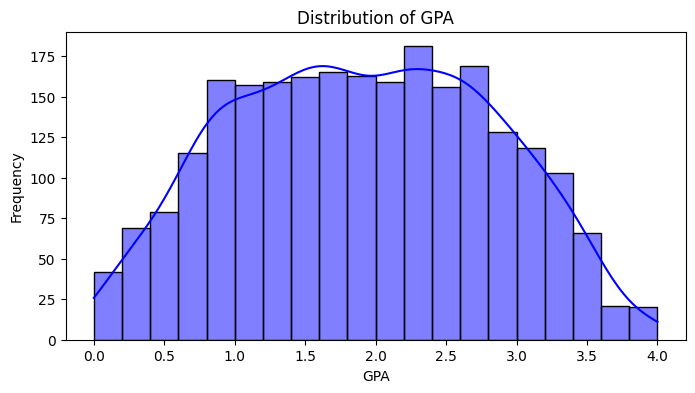

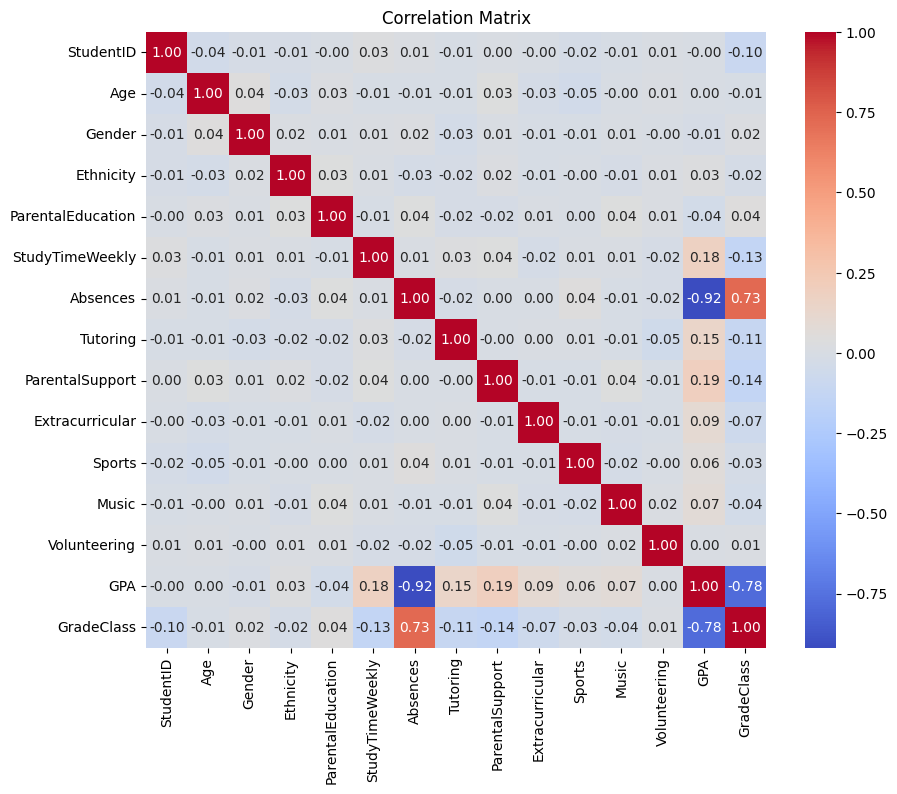

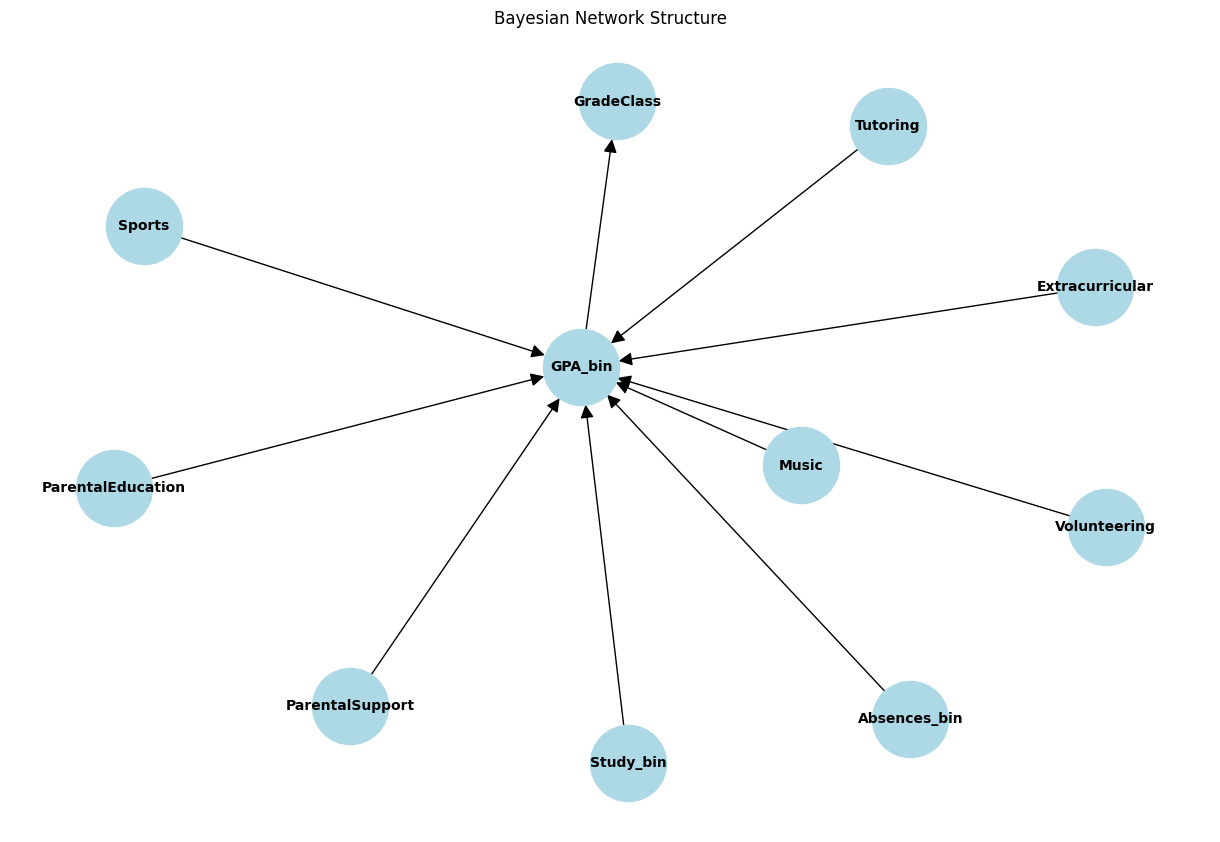

INFO:root:For GPA_bin: Used 645/1000 combinations (880 skipped)
INFO:root:For GradeClass: Used 4/4 combinations (0 skipped)
INFO:root:CPT for node Gender contains 2 entries.
INFO:root:CPT for node Ethnicity contains 4 entries.
INFO:root:CPT for node ParentalEducation contains 5 entries.
INFO:root:CPT for node Tutoring contains 2 entries.
INFO:root:CPT for node ParentalSupport contains 5 entries.
INFO:root:CPT for node Extracurricular contains 2 entries.
INFO:root:CPT for node Sports contains 2 entries.
INFO:root:CPT for node Music contains 2 entries.
INFO:root:CPT for node Volunteering contains 2 entries.
INFO:root:CPT for node Study_bin contains 4 entries.
INFO:root:CPT for node Absences_bin contains 5 entries.
INFO:root:CPT for node GPA_bin contains 645 entries.
INFO:root:CPT for node GradeClass contains 4 entries.
INFO:root:Model and mean GPA saved successfully to bayesian_model.pkl and mean_gpa.pkl.
INFO:root:MAE (GPA): 0.4485209036615003
INFO:root:RMSE (GPA): 0.5907524286423096
IN

In [2]:
# Cell 1: Import libraries and set logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import joblib
import logging
from itertools import product
import networkx as nx

logging.basicConfig(level=logging.INFO)

# Cell 2: Load dataset
df = pd.read_csv('data/Cleaned_Student_performance_data.csv')
logging.info(f"Dataset shape: {df.shape}")

# Cell 3: Analyze dataset
# Descriptive statistics
logging.info("Descriptive statistics:")
logging.info(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
logging.info(f"Missing values:\n{missing_values}")

# Handle missing values (if any)
df.fillna(df.median(), inplace=True)  # Replace missing values with median

# Visualize distributions of numerical features
numerical_cols = ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=20, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Analyze correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Cell 4: Discretize continuous features
gpa_bins   = [0, 1.0, 2.0, 3.0, 4.0]
gpa_labels = ['VeryLow', 'Low', 'Medium', 'High']
df['GPA_bin'] = pd.cut(df['GPA'], bins=gpa_bins, labels=gpa_labels, include_lowest=True)

study_bins   = [0, 5, 10, 15, 20, np.inf]
study_labels = ['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh']
df['Study_bin'] = pd.cut(df['StudyTimeWeekly'], bins=study_bins, labels=study_labels, include_lowest=True)

abs_bins   = [0, 5, 10, 15, 20, np.inf]
abs_labels = ['None', 'Few', 'Moderate', 'High', 'VeryHigh']
df['Absences_bin'] = pd.cut(df['Absences'], bins=abs_bins, labels=abs_labels, include_lowest=True)

# Cell 5: Encode categorical variables
categorical_cols = [
    'Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 
    'Extracurricular', 'Sports', 'Music', 'Volunteering', 'Study_bin', 'Absences_bin', 'GPA_bin', 'GradeClass'
]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Cell 6: Feature selection and data split
features = [
    'Gender', 'Ethnicity', 'ParentalEducation', 'Study_bin', 'Absences_bin', 
    'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering'
]
target_gpa   = 'GPA_bin'
target_class = 'GradeClass'

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[target_class]
)

# Cell 7: Define Bayesian Network structure
parents = {
    'Gender': [],
    'Ethnicity': [],
    'ParentalEducation': [],
    'Tutoring': [],
    'ParentalSupport': [],
    'Extracurricular': [],
    'Sports': [],
    'Music': [],
    'Volunteering': [],
    'Study_bin': [],
    'Absences_bin': [],
    'GPA_bin': ['Study_bin', 'ParentalEducation', 'Absences_bin', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering'],
    'GradeClass': ['GPA_bin']
}

# Visualize Bayesian Network structure
def visualize_bayesian_network(parents):
    G = nx.DiGraph()
    for child, pars in parents.items():
        for parent in pars:
            G.add_edge(parent, child)
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
    plt.title("Bayesian Network Structure")
    plt.show()

visualize_bayesian_network(parents)

# Modified Cell 8: Compute Conditional Probability Tables (CPTs) with better coverage
CPT = {}

# Improved hyperparameters
laplace_smoothing = 2  # Increased smoothing for better generalization
min_data_threshold = 5  # Lower threshold to include more combinations

# For GPA_bin, use a reduced feature set to improve coverage
important_gpa_features = ['Study_bin', 'ParentalEducation', 'Absences_bin', 'Tutoring', 'ParentalSupport']
parents['GPA_bin'] = important_gpa_features  # Use only the most important features

# Create simplified version of parents for the CPT
for node, pars in parents.items():
    if not pars:
        # For nodes without parents, calculate prior probabilities
        CPT[node] = train_df[node].value_counts(normalize=True).to_dict()
    else:
        # For nodes with parents, calculate conditional probabilities
        parent_values = [train_df[p].unique() for p in pars]
        combinations = list(product(*parent_values))
        table = {}
        classes = train_df[node].unique()
        
        # Track how many combinations are skipped
        skipped_combos = 0
        total_combos = len(combinations)
        
        for combo in combinations:
            # Create a mask for the current combination of parent values
            mask = np.ones(len(train_df), dtype=bool)
            for p, v in zip(pars, combo):
                mask &= (train_df[p] == v)
            subset = train_df[mask]

            # Check if the subset has enough data points
            if len(subset) < min_data_threshold:
                skipped_combos += 1
                # For GPA_bin, we'll use a simpler model to fill gaps
                if node == 'GPA_bin' and len(subset) > 0:
                    # Even with 1 or 2 samples, still calculate probabilities
                    counts = subset[node].value_counts()
                    total = counts.sum()
                    probs = {
                        c: (counts.get(c, 0) + laplace_smoothing) / (total + laplace_smoothing * len(classes))
                        for c in classes
                    }
                    table[combo] = probs
                continue

            # Calculate counts and probabilities with Laplace smoothing
            counts = subset[node].value_counts()
            total = counts.sum()
            probs = {
                c: (counts.get(c, 0) + laplace_smoothing) / (total + laplace_smoothing * len(classes))
                for c in classes
            }
            table[combo] = probs
        
        logging.info(f"For {node}: Used {len(table)}/{total_combos} combinations ({skipped_combos} skipped)")
        CPT[node] = table

# Log the size of each CPT
for node, table in CPT.items():
    logging.info(f"CPT for node {node} contains {len(table)} entries.")

# Create simplified predictors for fallback
simplified_predictors = {}
for target in ['GPA_bin', 'GradeClass']:
    # Create simple one-feature predictors for each parent
    parent_features = parents[target]
    for feature in parent_features:
        table = {}
        for value in train_df[feature].unique():
            subset = train_df[train_df[feature] == value]
            if len(subset) > 0:
                probs = {}
                for c in train_df[target].unique():
                    count = len(subset[subset[target] == c])
                    probs[c] = (count + laplace_smoothing) / (len(subset) + laplace_smoothing * len(train_df[target].unique()))
                table[value] = probs
        simplified_predictors[(target, feature)] = table


# Cell 9: Save model to .pkl
model_data = {
    'CPT': CPT,
    'parents': parents,
    'label_encoders': label_encoders,
    'features': features,
    'target_gpa': target_gpa,
    'target_class': target_class,
    'simplified_predictors': simplified_predictors
}
joblib.dump(model_data, 'models/bayesian_model.pkl')

mean_gpa = train_df.groupby('GPA_bin')['GPA'].mean().to_dict()
joblib.dump(mean_gpa, 'models/mean_gpa.pkl')

logging.info("Model and mean GPA saved successfully to bayesian_model.pkl and mean_gpa.pkl.")

# Cell 10: Define prediction functions
def predict_gpa_bin(row):
    key = tuple(row[p] for p in parents['GPA_bin'])
    if key in CPT['GPA_bin']:
        probs = CPT['GPA_bin'][key]
        return max(probs, key=probs.get)
    # Fallback: Use prior distribution
    prior = train_df['GPA_bin'].value_counts(normalize=True).to_dict()
    return max(prior, key=prior.get)

def predict_gradeclass(row):
    key = tuple(row[p] for p in parents['GradeClass'])
    if key in CPT['GradeClass']:
        probs = CPT['GradeClass'][key]
        return max(probs, key=probs.get)
    # Fallback: Use prior distribution
    prior = train_df['GradeClass'].value_counts(normalize=True).to_dict()
    return max(prior, key=prior.get)

# Cell 11: Predict and evaluate
test_df['Predicted_GPA_bin'] = test_df.apply(predict_gpa_bin, axis=1)
test_df['Predicted_GradeClass'] = test_df.apply(predict_gradeclass, axis=1)

# Evaluate GPA predictions
true_gpa = test_df['GPA']
predicted_gpa = test_df['Predicted_GPA_bin'].map(mean_gpa)
mae = mean_absolute_error(true_gpa, predicted_gpa)
rmse = np.sqrt(mean_squared_error(true_gpa, predicted_gpa))
logging.info(f"MAE (GPA): {mae}")
logging.info(f"RMSE (GPA): {rmse}")

# Evaluate GradeClass predictions
accuracy = accuracy_score(test_df['GradeClass'], test_df['Predicted_GradeClass'])
logging.info(f"Accuracy (GradeClass): {accuracy}")

# Cell 12: Save evaluation metrics
evaluation_metrics = {
    'MAE_GPA': mae,
    'RMSE_GPA': rmse,
    'Accuracy_GradeClass': accuracy
}
joblib.dump(evaluation_metrics, 'models/evaluation_metrics.pkl')
logging.info("Evaluation metrics saved successfully.")